# Мультиклассификация с помощью RNN

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
plt.style.use('seaborn')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
from skimage import transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from read_data import *
from read_data import good_cols
%matplotlib inline

In [10]:
class SignalDataset(Dataset):
    def __init__(self, data_X, data_Y):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X = data_X
        self.Y = data_Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        input_data = self.X[idx]
        label = self.Y[idx]
        
        return input_data, label

In [4]:
all_df = get_df()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:23<00:00,  2.64s/it]


### Выбираем длину

In [60]:
TARGET_LEN = 20000
activities = sep_by_len(all_df, TARGET_LEN)
activities.shape

(64, 32)

In [205]:
CUT_LEN = 1000
cut_df = cut_act(activities, CUT_LEN, count=20, random_start=True)
cut_df.sample()

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 20.52it/s]


,activityID,heart rate,temperature hand,3Da_x scale_16 hand,3Da_y scale_16 hand,3Da_z scale_16 hand,3Dg_x hand,3Dg_y hand,3Dg_z hand,3Dm_x hand,...,temperature ankle,3Da_x scale_16 ankle,3Da_y scale_16 ankle,3Da_z scale_16 ankle,3Dg_x ankle,3Dg_y ankle,3Dg_z ankle,3Dm_x ankle,3Dm_y ankle,3Dm_z ankle
504,3,"[104.0, 104.0, 104.0, 104.0, 104.0, 104.0, 104...","[33.0625, 33.0625, 33.0625, 33.0625, 33.0625, ...","[-8.56019, -8.52722, -8.52374, -8.49557, -8.44...","[4.49675, 4.57099, 4.49612, 4.45554, 4.34378, ...","[1.70561, 1.5519, 1.66767, 1.39881, 1.6693, 1....","[-0.0194474, 0.0325799, -0.00250761, -0.025882...","[0.0503358, 0.0574126, 0.0551736, 0.0308723, 0...","[0.0057868, 0.0167219, -0.0113833, -0.0283495,...","[29.7819, 29.4122, 29.8991, 29.7864, 29.2767, ...",...,"[33.875, 33.875, 33.875, 33.875, 33.875, 33.87...","[9.47476, 9.46926, 9.54611, 9.55001, 9.51078, ...","[0.571616, 0.573222, 0.534137, 0.647079, 0.723...","[-3.04832, -3.24133, -3.16312, -3.04801, -3.12...","[-0.00728005, 0.0217171, 0.00404677, -0.028358...","[-0.0243788, 0.00302756, -0.0180928, -0.017168...","[-0.0226631, -0.0223298, -0.00603188, -0.02658...","[-5.29849, -6.08204, -5.57461, -5.18128, -4.79...","[-0.193791, 0.358587, 0.720773, 0.444925, 0.42...","[27.7706, 27.1999, 27.6268, 28.054, 28.4809, 2..."


### Получаем признаки

In [206]:
X = cut_df.iloc[:, 1:].values

Y = cut_df.iloc[:, 0] # целевая переменная
X.shape, Y.shape

((1280, 31), (1280,))

In [213]:
y_targ = y_encode(Y)
np.unique(y_targ)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

### Нормализация

In [207]:
def normalize_dif_len(X_data) -> pd.DataFrame: # Исправить
    arr = []
    got_lenghts = False
    for col in X_data.T:
        
        colflat = [] 
        if not got_lenghts:
            lengths = []
        for traj_arr in col:
            colflat += list(traj_arr)
            if not got_lenghts:
                lengths.append(len(traj_arr))
        
        if not got_lenghts:
            got_lenghts = True
            
        col_arr = np.array(colflat, dtype=np.float64)
        
        x_mean = np.mean(col_arr)
        x_var = np.var(col_arr)
        col_arr -= x_mean
        if x_var:
            col_arr /= x_var
        else:
            col_arr *= 0
        
        col_arr_reshaped = []
        start = 0
        for i in range(len(lengths)):
            traj_arr = col_arr[start:start+lengths[i]]
            start += lengths[i]
            col_arr_reshaped.append(traj_arr)
            
        arr.append(col_arr_reshaped)
        
        
    return np.array(arr, dtype=object).T



In [208]:
X_norm = normalize_dif_len(X)
X_norm.shape

(1000, 1280, 31)

In [209]:
X_norm[2,3]

array([-0.004165141556342869, -0.7177268628374053, 0.2751444118686525,
       0.02720269465827064, 0.1314875650915503, -0.012524980443593002,
       -0.09343176093259686, -0.013727740003888714, -0.05848210853965814,
       0.05410598974382151, -0.09042271358378914, -1.76970079238292,
       0.23301616041989476, -0.32563557604663895, 0.41647239345882353,
       0.057571002737908765, -0.1581183909416413, 0.02658180362502283,
       0.12066559180450681, 0.11457235360467159, -0.11131945878276521,
       -2.567445359109842, -0.27997769762991054, -0.15001811376429652,
       -0.3552646842352143, 0.022483634413529414, 0.1319710558550384,
       0.006496999418262529, 0.04335423180289937, 0.09473450078201626,
       -0.06461929803735657], dtype=object)

### Приводим к одной длине

In [168]:
def get_equal_len(X, need_len=-1, fill_with=0): # Доделать
    '''
    By default sets all signals to len of signal with maximum length, putting fill_with to the end of signal
    If you know precise len you need, it can be changed, signals with bigger lenght would be cutted
    '''
    if need_len == -1:
        max_len = -1
        for sig_arr in X.T[0]:
            max_len = max(max_len, len(sig_arr))
        
        X_eq = []    
        for sig in X:
            sig_arr = np.array(list(sig), dtype=np.float64)
#             print(sig_arr.shape, max_len)
            z = np.zeros((sig_arr.shape[0], max_len-sig_arr.shape[1]), dtype=np.float64)
            new_arr = np.concatenate((sig_arr,z), axis=1)
#             print(new_arr.shape, max_len)
            X_eq.append(new_arr)
        return np.array(X_eq, dtype = np.float64)
        
    else: # Пока не сделано
        pass

In [176]:
X_eq = np.transpose(get_equal_len(X_norm), axes = [0,2,1])
X_eq.shape

(64, 37744, 31)

Вариант для малой длины

In [219]:
X_eq = np.transpose(np.array(X_norm,dtype=np.float64), axes = [1,0,2])
X_eq.shape

(1280, 1000, 31)

In [220]:
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = \
    train_test_split(torch.FloatTensor(X_eq), torch.LongTensor(y_targ), random_state=42, test_size = 0.2)
X_train_tensor.shape, y_train_tensor.shape, np.unique(y_train_tensor), np.unique(y_val_tensor)

(torch.Size([1024, 1000, 31]),
 torch.Size([1024]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64))

In [221]:
BATCH_SIZE = 64

trainset = SignalDataset(X_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

testset = SignalDataset(X_val_tensor, y_val_tensor)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)
len(trainset)

1024

## Подготовка модели

In [222]:
activation = nn.LeakyReLU

class RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, num_classes, seq_len):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim,num_classes)
#         self.rnn = nn.RNN(input_size = 31, hidden_size = 128, num_layers=1, batch_first = True, bidirectional = False, dropout=0)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        
        out, _ = self.rnn(x, (h0, c0))
#         out = out.reshape(out.shape[0], -1) # Если хотим выход через последний слой
        out = self.fc(out[:,-1,:]) # Если хотим видеть в выходе все слои
        return out
    
input_size = 31
hidden_dim = 128
num_layers = 1
num_classes = len(np.unique(y_targ))
seq_len = X_signal.shape[1]

net = RNN(input_size, hidden_dim, num_layers, num_classes, seq_len)

## Обучение

In [223]:
NUM_EPOCHS = 10

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
losses = []

learning_rate = 3e-3
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)
ebar = tqdm(range(NUM_EPOCHS))

for epoch_num in ebar:
    running_loss = 0.0
    iter_num = 0
#     pbar = tqdm(enumerate(trainloader), total = len(trainloader))
    pbar = enumerate(trainloader)
    for iter_num, (X_batch, y_batch) in pbar:
        iter_num +=1
        
        y_pred = net(X_batch)
        
        loss = loss_fn(y_pred, y_batch)
        running_loss += loss.item()
                     
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
    line = '[{}/{}] current loss: {}'.format(epoch_num+1, NUM_EPOCHS, running_loss/len(trainset))
    ebar.set_description(line)
    
    losses.append(running_loss/len(trainset))
        
    with torch.no_grad():
        y_pred = torch.softmax(net(X_val_tensor), 1)
        y = torch.argmax(y_pred, axis=1)
        line = '[{}/{}] current valid score: {}'.format(epoch_num+1, NUM_EPOCHS, f1_score(y_val_tensor, y, average='macro'))
        print(line)
#         ebar.set_description(line)

C:\Users\kitro\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
[1/10] current loss: 1.9516414925456047:  10%|████▏                                     | 1/10 [01:05<09:49, 65.53s/it]

[1/10] current valid score: 0.44596879039665116


[2/10] current loss: 1.3005515187978745:  20%|████████▍                                 | 2/10 [02:26<09:21, 70.21s/it]

[2/10] current valid score: 0.6055724449232467


[3/10] current loss: 0.9724844060838223:  30%|████████████▌                             | 3/10 [03:51<08:41, 74.46s/it]

[3/10] current valid score: 0.6361275716173143


[4/10] current loss: 0.797106571495533:  40%|█████████████████▏                         | 4/10 [05:05<07:26, 74.48s/it]

[4/10] current valid score: 0.7642189707754521


[5/10] current loss: 0.6732963509857655:  50%|█████████████████████                     | 5/10 [06:12<06:01, 72.25s/it]

[5/10] current valid score: 0.7901294688359365


[6/10] current loss: 1.0100587848573923:  60%|█████████████████████████▏                | 6/10 [07:19<04:42, 70.52s/it]

[6/10] current valid score: 0.6197124304267162


[7/10] current loss: 0.7526366896927357:  70%|█████████████████████████████▍            | 7/10 [08:24<03:26, 68.87s/it]

[7/10] current valid score: 0.7407592596271841


[8/10] current loss: 0.5855241362005472:  80%|█████████████████████████████████▌        | 8/10 [09:28<02:15, 67.66s/it]

[8/10] current valid score: 0.823652254497811


[9/10] current loss: 0.4778214171528816:  90%|█████████████████████████████████████▊    | 9/10 [10:33<01:06, 66.58s/it]

[9/10] current valid score: 0.8857830361344217


[10/10] current loss: 0.3896242827177048: 100%|████████████████████████████████████████| 10/10 [11:35<00:00, 69.51s/it]

[10/10] current valid score: 0.8887995327793162


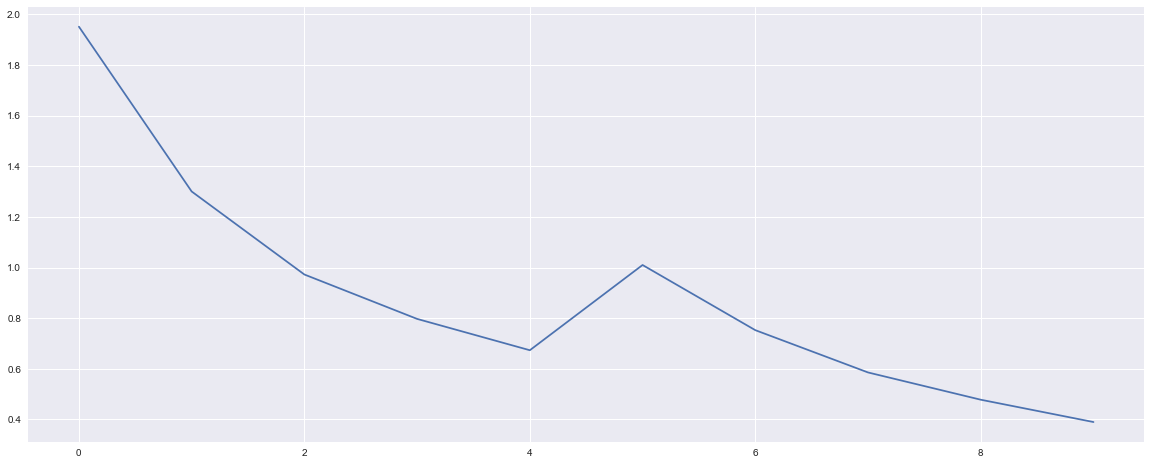

In [224]:
fig, axs = plt.subplots(1,1,figsize=(20,8))
plt.plot(np.arange(NUM_EPOCHS), losses)
plt.show()

### Оценка точности

In [225]:
for i in range(len(np.unique(y_val_tensor))):
    idx = np.argwhere(y_val_tensor==i)[0]
    y_pred = torch.sigmoid(net(X_val_tensor[idx]))
    y = torch.argmax(y_pred, axis=1)
    print(np.unique(Y)[i], len(y[y==i])/len(idx))

1 0.9615384615384616
2 0.6333333333333333
3 0.8048780487804879
4 1.0
5 1.0
6 0.92
7 0.8787878787878788
16 0.9393939393939394
17 0.8461538461538461


In [226]:
with torch.no_grad():
    y_pred = torch.softmax(net(X_val_tensor), 1)
    y = torch.argmax(y_pred, axis=1)
#     print(net(X_val_tensor).shape)
    print(roc_auc_score(y_val_tensor, y_pred, multi_class='ovo'))
    print(f1_score(y_val_tensor, y, average='macro'))

0.9853338073446051
0.8887995327793162
